In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn import metrics

In [2]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    
    return text

In [3]:
def create_text_info(df_text, df_class, time):
    n = len(df_class)
    
    X = []
    Y = []
    
    res = pd.DataFrame({'Event': [''] * len(df_class)}, index=df_class.index)
    events_txt_all = [''] * n
    
    for i in range(n):
        
        beg = df_class.index[i] - relativedelta(months = time)
        end = df_class.index[i]
        
        new = df_text.loc[(df_text.index >= beg) & (df_text.index <= end)]
        new_it = new['Event']
        n_event = len(new_it)
        
        if n_event != 0:
            events_txt_all[i] += new_it[0]
            for j in range(1, n_event):
                events_txt_all[i] += ' ' + new_it[j]
    
    res['Event'] = events_txt_all
    return res
    

In [4]:
def assign_events_to_classification(df_events, classes, time):
    event_assigned_df = create_text_info(df_events, classes, time)
    
    #print(event_assigned_df)
    event_assigned_df['Class'] = classes
    event_assigned_df['Class'] = event_assigned_df['Class'].apply(lambda x: str(int(x)))
    
    return event_assigned_df

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

def get_MultinomialNB(X_train, y_train):
    nb = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', MultinomialNB()),
                  ])
    
    nb.fit(X_train, y_train)
    
    return nb


from sklearn.linear_model import SGDClassifier

def get_SGDClassifier(X_train, y_train):

    sgd = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                   ])
    sgd.fit(X_train, y_train)
    
    return sgd


from sklearn.linear_model import LogisticRegression

def get_LogisticRegression(X_train, y_train):
    
    logreg = Pipeline([('vect', CountVectorizer()),
                       ('tfidf', TfidfTransformer()),
                       ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                      ])
    logreg.fit(X_train, y_train)
    
    return logreg

In [6]:
df_full = pd.read_csv("E:/SZAKDOLGOZAT/KUTATAS/YEARS/final/0xYEARS.csv", index_col = "Date", parse_dates = True)
df_full_cleared = df_full['Event'].apply(clean_text)
df_full_cleared_final = pd.DataFrame({'Event': df_full_cleared}, index=df_full.index)
labels_6class = ['0', '1', '2', '3', '4', '5']
labels_4class = ['0', '1', '2', '3']
labels_3class = ['0', '1', '2']

C:\Users\Etele\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [7]:
source_classes = "E:/SZAKDOLGOZAT/KUTATAS/CLASSIFICATION/XOM_fully_classified.csv"
xom_all_classes = pd.read_csv(source_classes, index_col = "Date", parse_dates = True)

C:\Users\Etele\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TRAIN MultinomialNB xom accuracy %s 0.4837171052631579
TEST MultinomialNB xom accuracy %s 0.3134920634920635

TRAIN SGDClassifier xom accuracy %s 0.5018092105263158
TEST SGDClassifier xom accuracy %s 0.30158730158730157

TRAIN LogisticRegression xom accuracy %s 0.5860197368421053
TEST LogisticRegression xom accuracy %s 0.30158730158730157



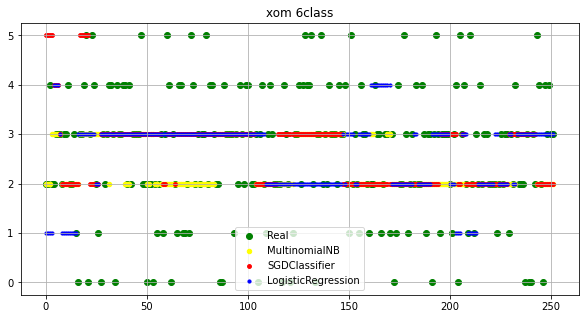

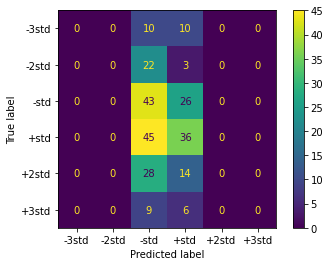

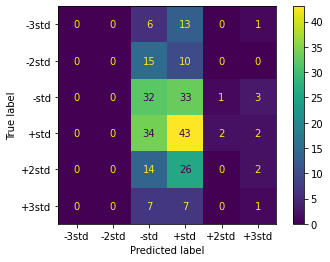

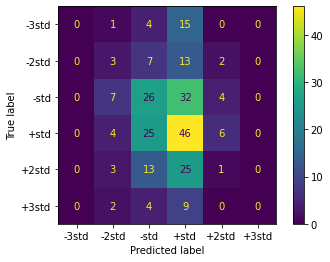

In [8]:
event_6class_xom = assign_events_to_classification(df_full_cleared_final, xom_all_classes['1_day_even_6class'][20:-1], 1)

train_xom_6class = event_6class_xom[:-252]
test_xom_6class = event_6class_xom[-252:]

nb_6class_xom = get_MultinomialNB(train_xom_6class['Event'], train_xom_6class['Class'])
sgd_6class_xom = get_SGDClassifier(train_xom_6class['Event'], train_xom_6class['Class'])
logreg_6class_xom = get_LogisticRegression(train_xom_6class['Event'], train_xom_6class['Class'])

##############################################################################################################
nb_train_pred_6class_xom = nb_6class_xom.predict(train_xom_6class['Event'])
nb_test_pred_6class_xom = nb_6class_xom.predict(test_xom_6class['Event'])
print('TRAIN MultinomialNB xom accuracy %s', accuracy_score(nb_train_pred_6class_xom, train_xom_6class['Class']))
print('TEST MultinomialNB xom accuracy %s', accuracy_score(nb_test_pred_6class_xom, test_xom_6class['Class']))
print()

nb_test_pred_6class_xom_num = []
for r in nb_test_pred_6class_xom:
    nb_test_pred_6class_xom_num.append(int(r))
##############################################################################################################
sgd_train_pred_6class_xom = sgd_6class_xom.predict(train_xom_6class['Event'])
sgd_test_pred_6class_xom = sgd_6class_xom.predict(test_xom_6class['Event'])  
print('TRAIN SGDClassifier xom accuracy %s', accuracy_score(sgd_train_pred_6class_xom, train_xom_6class['Class']))
print('TEST SGDClassifier xom accuracy %s', accuracy_score(sgd_test_pred_6class_xom, test_xom_6class['Class']))
print()

sgd_test_pred_6class_xom_num = []
for r in sgd_test_pred_6class_xom:
    sgd_test_pred_6class_xom_num.append(int(r))
##############################################################################################################
logreg_train_pred_6class_xom = logreg_6class_xom.predict(train_xom_6class['Event'])
logreg_test_pred_6class_xom = logreg_6class_xom.predict(test_xom_6class['Event'])    
print('TRAIN LogisticRegression xom accuracy %s', accuracy_score(logreg_train_pred_6class_xom, train_xom_6class['Class']))
print('TEST LogisticRegression xom accuracy %s', accuracy_score(logreg_test_pred_6class_xom, test_xom_6class['Class']))
print()

logreg_test_pred_6class_xom_num = []
for r in logreg_test_pred_6class_xom:
    logreg_test_pred_6class_xom_num.append(int(r))
##############################################################################################################
##############################################################################################################

fig, ax = plt.subplots(figsize=(10, 5))
plt.grid(visible = True)
plt.title("xom 6class")
plt.scatter(np.linspace(0,251,252), xom_all_classes['1_day_even_6class'][-253:-1], color = 'green', label = 'Real')
plt.scatter(np.linspace(0,251,252), nb_test_pred_6class_xom_num, color = 'yellow', label = 'MultinomialNB ', s = 20)
plt.scatter(np.linspace(0,251,252), sgd_test_pred_6class_xom_num, color = 'red', label = 'SGDClassifier', s = 15)
plt.scatter(np.linspace(0,251,252), logreg_test_pred_6class_xom_num, color = 'blue', label = 'LogisticRegression', s = 10)
plt.legend()

nb_confusion_matrix_6class_xom = metrics.confusion_matrix(test_xom_6class['Class'], nb_test_pred_6class_xom)
nb_cm_xomplay_6class_xom = metrics.ConfusionMatrixDisplay(confusion_matrix = nb_confusion_matrix_6class_xom, display_labels = ["-3std", "-2std","-std","+std", "+2std", "+3std"])
nb_cm_xomplay_6class_xom.plot()

sgd_confusion_matrix_6class_xom = metrics.confusion_matrix(test_xom_6class['Class'], sgd_test_pred_6class_xom)
sgd_cm_xomplay_6class_xom = metrics.ConfusionMatrixDisplay(confusion_matrix = sgd_confusion_matrix_6class_xom, display_labels = ["-3std", "-2std","-std","+std", "+2std", "+3std"])
sgd_cm_xomplay_6class_xom.plot()

logreg_confusion_matrix_6class_xom = metrics.confusion_matrix(test_xom_6class['Class'], logreg_test_pred_6class_xom)
logreg_cm_xomplay_6class_xom = metrics.ConfusionMatrixDisplay(confusion_matrix = logreg_confusion_matrix_6class_xom, display_labels = ["-3std", "-2std","-std","+std", "+2std", "+3std"])
logreg_cm_xomplay_6class_xom.plot()

plt.show()

C:\Users\Etele\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TRAIN MultinomialNB xom accuracy %s 0.490625
TEST MultinomialNB xom accuracy %s 0.3134920634920635

TRAIN SGDClassifier xom accuracy %s 0.5083881578947368
TEST SGDClassifier xom accuracy %s 0.28174603174603174

TRAIN LogisticRegression xom accuracy %s 0.5996710526315789
TEST LogisticRegression xom accuracy %s 0.2896825396825397



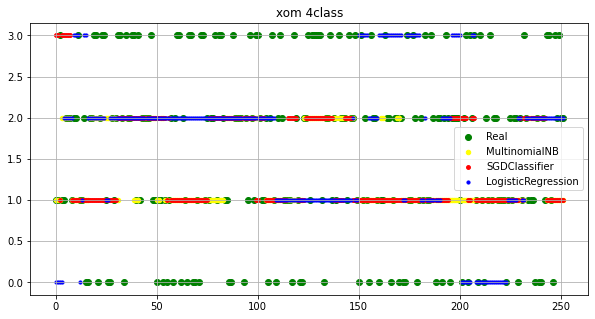

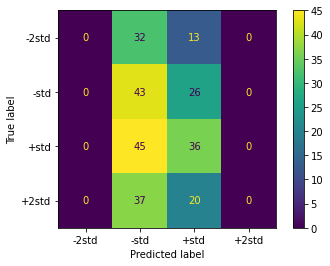

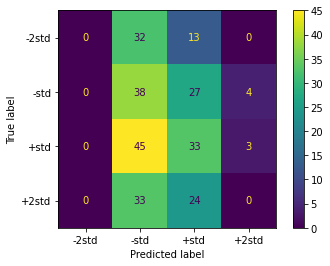

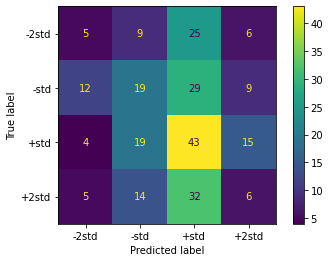

In [9]:
event_4class_xom = assign_events_to_classification(df_full_cleared_final, xom_all_classes['1_day_even_4class'][20:-1], 1)

train_xom_4class = event_4class_xom[:-252]
test_xom_4class = event_4class_xom[-252:]

nb_4class_xom = get_MultinomialNB(train_xom_4class['Event'], train_xom_4class['Class'])
sgd_4class_xom = get_SGDClassifier(train_xom_4class['Event'], train_xom_4class['Class'])
logreg_4class_xom = get_LogisticRegression(train_xom_4class['Event'], train_xom_4class['Class'])

##############################################################################################################
nb_train_pred_4class_xom = nb_4class_xom.predict(train_xom_4class['Event'])
nb_test_pred_4class_xom = nb_4class_xom.predict(test_xom_4class['Event'])
print('TRAIN MultinomialNB xom accuracy %s', accuracy_score(nb_train_pred_4class_xom, train_xom_4class['Class']))
print('TEST MultinomialNB xom accuracy %s', accuracy_score(nb_test_pred_4class_xom, test_xom_4class['Class']))
print()

nb_test_pred_4class_xom_num = []
for r in nb_test_pred_4class_xom:
    nb_test_pred_4class_xom_num.append(int(r))
##############################################################################################################
sgd_train_pred_4class_xom = sgd_4class_xom.predict(train_xom_4class['Event'])
sgd_test_pred_4class_xom = sgd_4class_xom.predict(test_xom_4class['Event'])  
print('TRAIN SGDClassifier xom accuracy %s', accuracy_score(sgd_train_pred_4class_xom, train_xom_4class['Class']))
print('TEST SGDClassifier xom accuracy %s', accuracy_score(sgd_test_pred_4class_xom, test_xom_4class['Class']))
print()

sgd_test_pred_4class_xom_num = []
for r in sgd_test_pred_4class_xom:
    sgd_test_pred_4class_xom_num.append(int(r))
##############################################################################################################
logreg_train_pred_4class_xom = logreg_4class_xom.predict(train_xom_4class['Event'])
logreg_test_pred_4class_xom = logreg_4class_xom.predict(test_xom_4class['Event'])    
print('TRAIN LogisticRegression xom accuracy %s', accuracy_score(logreg_train_pred_4class_xom, train_xom_4class['Class']))
print('TEST LogisticRegression xom accuracy %s', accuracy_score(logreg_test_pred_4class_xom, test_xom_4class['Class']))
print()

logreg_test_pred_4class_xom_num = []
for r in logreg_test_pred_4class_xom:
    logreg_test_pred_4class_xom_num.append(int(r))
##############################################################################################################
##############################################################################################################

fig, ax = plt.subplots(figsize=(10, 5))
plt.grid(visible = True)
plt.title("xom 4class")
plt.scatter(np.linspace(0,251,252), xom_all_classes['1_day_even_4class'][-253:-1], color = 'green', label = 'Real')
plt.scatter(np.linspace(0,251,252), nb_test_pred_4class_xom_num, color = 'yellow', label = 'MultinomialNB ', s = 20)
plt.scatter(np.linspace(0,251,252), sgd_test_pred_4class_xom_num, color = 'red', label = 'SGDClassifier', s = 15)
plt.scatter(np.linspace(0,251,252), logreg_test_pred_4class_xom_num, color = 'blue', label = 'LogisticRegression', s = 10)
plt.legend()

nb_confusion_matrix_4class_xom = metrics.confusion_matrix(test_xom_4class['Class'], nb_test_pred_4class_xom)
nb_cm_xomplay_4class_xom = metrics.ConfusionMatrixDisplay(confusion_matrix = nb_confusion_matrix_4class_xom, display_labels = ["-2std","-std","+std", "+2std"])
nb_cm_xomplay_4class_xom.plot()

sgd_confusion_matrix_4class_xom = metrics.confusion_matrix(test_xom_4class['Class'], sgd_test_pred_4class_xom)
sgd_cm_xomplay_4class_xom = metrics.ConfusionMatrixDisplay(confusion_matrix = sgd_confusion_matrix_4class_xom, display_labels = ["-2std","-std","+std", "+2std"])
sgd_cm_xomplay_4class_xom.plot()

logreg_confusion_matrix_4class_xom = metrics.confusion_matrix(test_xom_4class['Class'], logreg_test_pred_4class_xom)
logreg_cm_xomplay_4class_xom = metrics.ConfusionMatrixDisplay(confusion_matrix = logreg_confusion_matrix_4class_xom, display_labels = ["-2std","-std","+std", "+2std"])
logreg_cm_xomplay_4class_xom.plot()

plt.show()

C:\Users\Etele\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


TRAIN MultinomialNB xom accuracy %s 0.5166118421052631
TEST MultinomialNB xom accuracy %s 0.3412698412698413

TRAIN SGDClassifier xom accuracy %s 0.5366776315789473
TEST SGDClassifier xom accuracy %s 0.3412698412698413

TRAIN LogisticRegression xom accuracy %s 0.6333881578947368
TEST LogisticRegression xom accuracy %s 0.30952380952380953



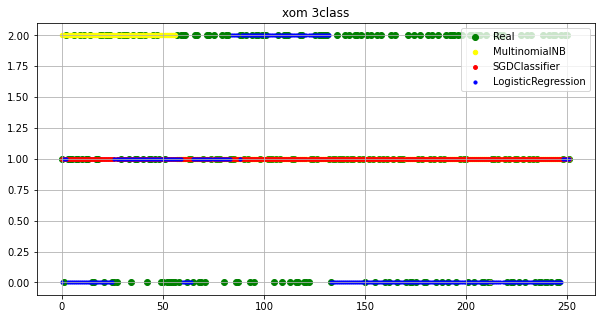

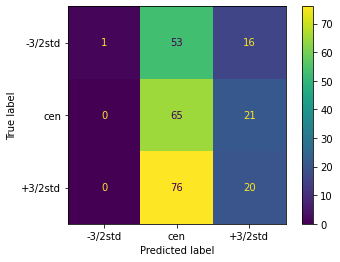

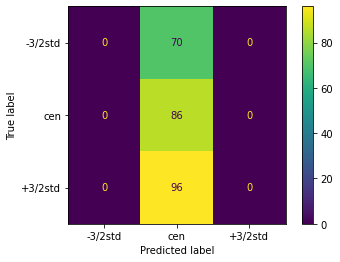

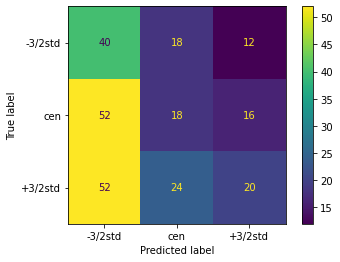

In [10]:
event_3class_xom = assign_events_to_classification(df_full_cleared_final, xom_all_classes['1_day_odd_3class'][20:-1], 3)

train_xom_3class = event_3class_xom[:-252]
test_xom_3class = event_3class_xom[-252:]

nb_3class_xom = get_MultinomialNB(train_xom_3class['Event'], train_xom_3class['Class'])
sgd_3class_xom = get_SGDClassifier(train_xom_3class['Event'], train_xom_3class['Class'])
logreg_3class_xom = get_LogisticRegression(train_xom_3class['Event'], train_xom_3class['Class'])

##############################################################################################################
nb_train_pred_3class_xom = nb_3class_xom.predict(train_xom_3class['Event'])
nb_test_pred_3class_xom = nb_3class_xom.predict(test_xom_3class['Event'])
print('TRAIN MultinomialNB xom accuracy %s', accuracy_score(nb_train_pred_3class_xom, train_xom_3class['Class']))
print('TEST MultinomialNB xom accuracy %s', accuracy_score(nb_test_pred_3class_xom, test_xom_3class['Class']))
print()

nb_test_pred_3class_xom_num = []
for r in nb_test_pred_3class_xom:
    nb_test_pred_3class_xom_num.append(int(r))
##############################################################################################################
sgd_train_pred_3class_xom = sgd_3class_xom.predict(train_xom_3class['Event'])
sgd_test_pred_3class_xom = sgd_3class_xom.predict(test_xom_3class['Event'])  
print('TRAIN SGDClassifier xom accuracy %s', accuracy_score(sgd_train_pred_3class_xom, train_xom_3class['Class']))
print('TEST SGDClassifier xom accuracy %s', accuracy_score(sgd_test_pred_3class_xom, test_xom_3class['Class']))
print()

sgd_test_pred_3class_xom_num = []
for r in sgd_test_pred_3class_xom:
    sgd_test_pred_3class_xom_num.append(int(r))
##############################################################################################################
logreg_train_pred_3class_xom = logreg_3class_xom.predict(train_xom_3class['Event'])
logreg_test_pred_3class_xom = logreg_3class_xom.predict(test_xom_3class['Event'])    
print('TRAIN LogisticRegression xom accuracy %s', accuracy_score(logreg_train_pred_3class_xom, train_xom_3class['Class']))
print('TEST LogisticRegression xom accuracy %s', accuracy_score(logreg_test_pred_3class_xom, test_xom_3class['Class']))
print()

logreg_test_pred_3class_xom_num = []
for r in logreg_test_pred_3class_xom:
    logreg_test_pred_3class_xom_num.append(int(r))
##############################################################################################################
##############################################################################################################

fig, ax = plt.subplots(figsize=(10, 5))
plt.grid(visible = True)
plt.title("xom 3class")
plt.scatter(np.linspace(0,251,252), xom_all_classes['1_day_odd_3class'][-253:-1], color = 'green', label = 'Real')
plt.scatter(np.linspace(0,251,252), nb_test_pred_3class_xom_num, color = 'yellow', label = 'MultinomialNB ', s = 20)
plt.scatter(np.linspace(0,251,252), sgd_test_pred_3class_xom_num, color = 'red', label = 'SGDClassifier', s = 15)
plt.scatter(np.linspace(0,251,252), logreg_test_pred_3class_xom_num, color = 'blue', label = 'LogisticRegression', s = 10)
plt.legend()

nb_confusion_matrix_3class_xom = metrics.confusion_matrix(test_xom_3class['Class'], nb_test_pred_3class_xom)
nb_cm_xomplay_3class_xom = metrics.ConfusionMatrixDisplay(confusion_matrix = nb_confusion_matrix_3class_xom, display_labels = ["-3/2std", "cen", "+3/2std"])
nb_cm_xomplay_3class_xom.plot()

sgd_confusion_matrix_3class_xom = metrics.confusion_matrix(test_xom_3class['Class'], sgd_test_pred_3class_xom)
sgd_cm_xomplay_3class_xom = metrics.ConfusionMatrixDisplay(confusion_matrix = sgd_confusion_matrix_3class_xom, display_labels = ["-3/2std", "cen", "+3/2std"])
sgd_cm_xomplay_3class_xom.plot()

logreg_confusion_matrix_3class_xom = metrics.confusion_matrix(test_xom_3class['Class'], logreg_test_pred_3class_xom)
logreg_cm_xomplay_3class_xom = metrics.ConfusionMatrixDisplay(confusion_matrix = logreg_confusion_matrix_3class_xom, display_labels = ["-3/2std", "cen", "+3/2std"])
logreg_cm_xomplay_3class_xom.plot()

plt.show()

In [15]:
print("nb_6class_xom_res_num =", nb_test_pred_6class_xom_num)
print("sgd_6class_xom_res_num =", sgd_test_pred_6class_xom_num)
print("logreg_6class_xom_res_num =", logreg_test_pred_6class_xom_num)
print()
print("nb_4class_xom_res_num =", nb_test_pred_4class_xom_num)
print("sgd_4class_xom_res_num =", sgd_test_pred_4class_xom_num)
print("logreg_4class_xom_res_num =", logreg_test_pred_4class_xom_num)
print()
print("nb_3class_xom_res_num =", nb_test_pred_3class_xom_num)
print("sgd_3class_xom_res_num =", sgd_test_pred_3class_xom_num)
print("logreg_3class_xom_res_num =", logreg_test_pred_3class_xom_num)

nb_6class_xom_res_num = [2, 2, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2]
sgd_6class_xom_res_num = [5, 5, 5, 5, 4, 4, 4, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2